## Pulling in additional bands from the Planetary Computer

This notebook provides a supplementary tutorial for DrivenData's [On Cloud N: Cloud Cover Detection](https://www.drivendata.org/competitions/83/) competition.

The competition dataset includes four bands of imagery covering the visible and near infrared spectrum. You can access many more bands for the same chips via Microsoft's [Planetary Computer STAC API](https://www.drivendata.org/competitions/83/cloud-cover/page/400/). You may pull in any additional information from the Planetary Computer to supplement the provided data.

**This notebook demonstrates how to pull in an additional band of data from the Planetary Computer STAC API for each training chip.**

Notebook contents:
* [Set up](#set-up): load the data and define useful helper functions
* [Walk through pulling in an additional band](#example-chip): walk through the process of pulling in an additional band for one example chip
* [Refactor process](#refactor): consolidate the process into organized functions, and demonstrate how to iterate over all chips

In [1]:
%%capture
!pip install pandas_path loguru nb_black typing

In [2]:
# load extension for automatic formatting
%load_ext lab_black

import os

import matplotlib.pyplot as plt
import pandas as pd
from pandas_path import path  # noqa
from pathlib import Path
from tqdm import tqdm
from typing import Optional, List

<a id='set-up'></a>

### Set up

#### Load the data

In [3]:
DATA_DIR = Path("/driven-data/cloud-cover")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [4]:
BANDS = ["B02", "B03", "B04", "B08"]

In [5]:
# load the provided metadata
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


#### Helper functions

In [6]:
import rioxarray
import xrspatial.multispectral as ms


def true_color_img(chip_id: str, data_dir: os.PathLike = TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images
    and a chip id, plots the true color image of the chip"""
    chip_dir = data_dir / chip_id
    red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
    green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
    blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()

    return ms.true_color(r=red, g=green, b=blue)

In [7]:
import rasterio.warp


def lat_lon_bounds(filepath: os.PathLike):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    return rasterio.warp.transform_bounds(
        meta["crs"],
        4326,  # code for the lat-lon coordinate system
        *bounds,
    )

In [8]:
def add_paths(
    df: pd.DataFrame,
    feature_dir: os.PathLike,
    label_dir: Optional[os.PathLike] = None,
    bands: List[str] = BANDS,
):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column for
    each of the bands provided as "{band}_path", eg "B02_path". Each band column is
    the path to that band saved as a TIF image. If the path to the labels directory
    is provided, a column is also added to the dataframe with paths to the label TIF.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)["label_path"].path.exists().all()

    return df

In [9]:
train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_labels/adwp.tif
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_labels/adwu.tif
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_labels/adwz.tif
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_features/adxp/B...,/driven-data/cloud-cover/train_labels/adxp.tif
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_features/aeaj/B...,/driven-data/cloud-cover/train_labels/aeaj.tif


#### Example chip

Pick a random example chip to use

In [10]:
example_chip = train_meta.sample(n=1, random_state=13).iloc[0]
example_chip

chip_id                                                    mtmo
location                                                Kolwezi
datetime                                   2020-04-30T08:43:07Z
cloudpath                            az://./train_features/mtmo
B02_path      /driven-data/cloud-cover/train_features/mtmo/B...
B03_path      /driven-data/cloud-cover/train_features/mtmo/B...
B04_path      /driven-data/cloud-cover/train_features/mtmo/B...
B08_path      /driven-data/cloud-cover/train_features/mtmo/B...
label_path       /driven-data/cloud-cover/train_labels/mtmo.tif
Name: 5703, dtype: object

[Kolwezi](https://www.google.com/maps/place/Kolwezi,+Democratic+Republic+of+the+Congo/@-10.7239211,25.4629605,13z/data=!3m1!4b1!4m5!3m4!1s0x1979e57971072e4f:0xa23ff3e3cd0d2277!8m2!3d-10.7275273!4d25.5088914) is a city in the southern Democratic Republic of the Congo.

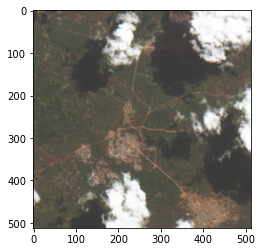

In [11]:
true_color_chip = true_color_img(example_chip.chip_id)
plt.imshow(true_color_chip)

<a id='example-chip'></a>

### Walk through pulling in an additional band

In this section, we'll walk through the process of pulling in an additional band for one example chip. The general steps to pull in an additional band are:

1. Establish a connection to the STAC API using the `planetary_computer` and `pystac_client` Python packages.
1. Query the STAC API for the Sentinel-2 scene that contains the desired chip. The query uses the chip's latitude and longitude bounds and timestamp. To account for small differences in the timestamps, we'll pass in a time range. We'll use 30 minutes before and after the chip timestamp.
1. Crop the scene to the bounding box of the chip.
1. Optionally, resize the new image to account for resolution differences.

In [12]:
from datetime import timedelta

import planetary_computer as pc
from pystac_client import Client

# Establish a connection to the STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collection = catalog.get_collection("sentinel-2-l2a")

In [13]:
# Get the chip bounding box latitudes and longitudes
left, bottom, right, top = lat_lon_bounds(example_chip.B04_path)
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [right, bottom],
            [left, bottom],
            [left, top],
            [right, top],
            [right, bottom],
        ]
    ],
}
area_of_interest

{'type': 'Polygon',
 'coordinates': [[[25.88589523290886, -10.75304696565266],
   [25.838905933504083, -10.75304696565266],
   [25.838905933504083, -10.70657886893391],
   [25.88589523290886, -10.70657886893391],
   [25.88589523290886, -10.75304696565266]]]}

In [14]:
# Get the chip timestamp and construct a time range for the query
DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"

chip_time = pd.to_datetime(example_chip.datetime)
range_start = pd.to_datetime(chip_time) - timedelta(minutes=30)
range_end = chip_time + timedelta(minutes=30)
time_range = (
    f"{range_start.strftime(DATETIME_FORMAT)}/{range_end.strftime(DATETIME_FORMAT)}"
)

print("Query time range:", time_range)

Query time range: 2020-04-30T08:13:07Z/2020-04-30T09:13:07Z


In [15]:
# Search the Sentinel-2 catalog for matching items
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_range,
)

print(f"""{"Chip time":<16}\t{chip_time}""")
print(f"""{"Search range start":<16}\t{range_start}""")
print(f"Search returned {len(list(search.get_items()))} item(s)")
for item in search.get_items():
    print(f"""\t{"Item time":<16}{item.datetime}""")
print(f"""{"Search range end":<16}\t{range_end}""")

Chip time       	2020-04-30 08:43:07+00:00
Search range start	2020-04-30 08:13:07+00:00
Search returned 1 item(s)
	Item time       2020-04-30 08:15:59.024000+00:00
Search range end	2020-04-30 09:13:07+00:00


In this case only one result was returned, but there's a chance that multiple results will match the query time range. In that case, we'll choose the result that has the maximum geographic overlap with our competition chip. If multiple results have equal overlap, we'll take the one with the closest timestamp.

The STAC API hosts Sentinel-2 "scenes" which are much larger than individual chips, so we'll need to crop the result to the spatial extent of our chip.

Again we'll need to be careful about the coordinate system. Chips are derived from the Sentinel-2 scenes, so the chip and resulting scene will probably match. We'll check just in case and transform the coordinates if they don't match.

In [16]:
geotiff = rasterio.open(example_chip["B04_path"])

if geotiff.meta["crs"] == item.properties["proj:epsg"]:
    print(f"""GeoTIFF and STAC item have same CRS {geotiff.meta["crs"]}""")
    bounds = geotiff.bounds
else:
    print(
        f"""Transforming from {geotiff.meta["crs"]} to {item.properties["proj:epsg"]}"""
    )
    bounds = rasterio.warp.transform_bounds(
        geotiff.meta["crs"],
        item.properties["proj:epsg"],
        geotiff.bounds.left,
        geotiff.bounds.bottom,
        geotiff.bounds.right,
        geotiff.bounds.top,
    )

GeoTIFF and STAC item have same CRS EPSG:32735


Each scene includes a number of bands or assets. Assets are of varying resolutions and numbers of channels. As you can see, there's a lot of potential for getting creative with feature engineering! 

For now, we'll pull in the band B11. The B11 band captures short-wave infrared light (SWIR) with a resolution of 20m (i.e., each pixel is 20x20m). We'll also pull in the visual band for comparison with our true color chip image derived from the competition data.

In [17]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

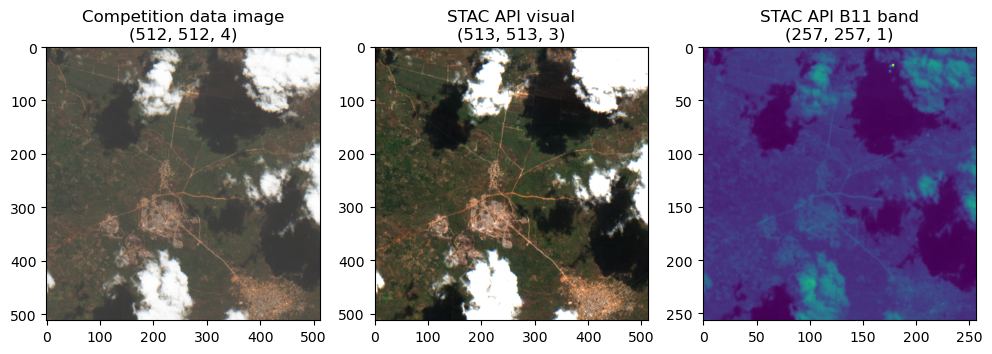

In [18]:
stac_visual = (
    rioxarray.open_rasterio(pc.sign(item.assets["visual"].href))
    .rio.clip_box(*bounds)
    .load()
    .transpose("y", "x", "band")
)

asset = "B11"
stac_additional_band = (
    rioxarray.open_rasterio(pc.sign(item.assets[asset].href))
    .rio.clip_box(*bounds)
    .load()
    .transpose("y", "x", "band")
)

fig, axs = plt.subplots(1, 3, dpi=100, figsize=(12, 4))

axs[0].imshow(true_color_chip)
axs[0].set_title(f"Competition data image\n{true_color_chip.shape}")

axs[1].imshow(stac_visual)
axs[1].set_title(f"STAC API visual\n{stac_visual.shape}")

axs[2].imshow(stac_additional_band)
axs[2].set_title(f"STAC API {asset} band\n{stac_additional_band.shape}")
plt.show()

You can see that the chips match visually. 

Due to the fact that bounding boxes are floating point latitude-longitude and pixels are integer values, there may be a one-pixel mismatch between the competition chip size and the returned imagery. All of the competition feature data chips are 512x512. The mismatch should be small enough that simply resizing shouldn't introduce too much error.

It's easy to imagine how these additional bands could contain valuable new information you could use to improve your model! 

<a id='refactor'></a>

### Refactor process and run on all data

Let's consolidate the code above into organized functions, so that we can easily iterate over the training chips and pull in a new band for each chip.

The cell below defines two functions to take a chip GeoTIFF and list of band assets IDs, and output the corresponding images. 

- `get_closest_item`: A function to narrow down a list of PySTAC items to the one that most closely matches the original chip
- `query_bands`: An end-to-end function to query the Planetary Computer STAC API for additional assets given a GeoTIFF, it's timestamp, and it's bounds. `query_bands` calls `get_closest_item`

This cell can also be written out as a standalone script, so you can run the process wherever you want.

In [19]:
from datetime import datetime, timedelta
from typing import Dict, Optional, Sequence, Tuple, Union

from loguru import logger
import numpy as np
import pandas as pd

from PIL import Image
import planetary_computer as pc
from pystac_client import Client
import shapely.geometry
import rasterio
import rioxarray

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"


catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collection = catalog.get_collection("sentinel-2-l2a")


def get_closest_item(
    items: Sequence[dict],
    polygon: shapely.geometry.polygon.Polygon,
    timestamp: datetime,
) -> Optional[dict]:
    """
    Returns the item with maximum overlap and closest timestamp.

    Args:
        items (Sequence[dict]): items returned by a PySTAC catalog search
        polygon (shapely.geometry.polygon.Poylgon): polygon of the latitude/longitude
            coordinates for the original chip to be matched
        timestamp (datetime.timestamp): timestamp for the original chip to be matched

    Returns:
        pystac.item.Item: PySTAC item with the maximum geographic overlap to the
            original chip to be matched. If multiple items have equal overlap, the
            item with the closest timestamp is returned.
    """
    # Convert consumable iterators to lists
    items = list(items)

    # Compute overlap between each query result and the geotiff polygon
    overlaps = [
        shapely.geometry.shape(item.geometry).intersection(polygon).area / polygon.area
        for item in items
    ]
    max_overlap = max(overlaps)
    items_overlaps = [
        (item, overlap)
        for item, overlap in zip(items, overlaps)
        if overlap == max_overlap
    ]

    # If one item has higher overlap than the rest, return it
    if len(items_overlaps) == 1:
        return items_overlaps[0][0]

    # If multiple items have equally high overlap, return the one with the closest timestamp
    min_timedelta = timedelta.max
    best_item = None
    for item, overlap in items_overlaps:
        item_timedelta = abs(item.datetime.astimezone(timestamp.tzinfo) - timestamp)
        if item_timedelta < min_timedelta:
            min_timedelta = item_timedelta
            best_item = item

    return best_item


def query_bands(
    geotiff: rasterio.io.DatasetReader,
    timestamp: Union[datetime, pd.Timestamp, str],
    asset_keys: Sequence[str],
    query_range_minutes: int = 120,
    output_shape: Optional[Tuple[int, int]] = None,
    verbose: Optional[bool] = True,
) -> Dict[str, np.ndarray]:
    """
    Queries the Planetary Computer STAC API for additional imagery that
    corresponds to the same spatial extent as a provided GeoTIFF.

    Args:
        geotiff (rasterio.io.DatasetReader): A rasterio GeoTIFF
        timestamp (datetime or str): Timestamp for GeoTIFF acquisition used
            in the STAC API query to find the corresponding scene
        asset_keys (sequence of str): A sequence (list, tuple, set, etc.) of
            keys specifying the desired STAC assets to return
        query_range_minutes (int): Duration of the time range for the STAC API
            query. You can increase this if the query does not return any results.
        output_shape (tuple of ints, optional): If provided, reshape the output
            to this (height, width)
        verbose (bool, Optional): Whether to print logging messages. Defaults to True

    Returns:
        dict {str: np.ndarray}: A dictionary where each key is an asset name, and each value
            is the array of values for that asset from the PySTAC item that most closely
            matches the original chip's location and time
    """
    # Convert bounds to regular lat/long coordinates
    left, bottom, right, top = rasterio.warp.transform_bounds(
        geotiff.meta["crs"],
        4326,  # code for the lat-lon coordinate system
        *geotiff.bounds,
    )

    # Get a polygon for the area to search
    area_of_interest = shapely.geometry.shape(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [left, bottom],
                    [left, top],
                    [right, top],
                    [right, bottom],
                    [left, bottom],
                ]
            ],
        }
    )

    # Get the timestamp range to search
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp)
    if isinstance(timestamp, pd.Timestamp):
        timestamp = timestamp.to_pydatetime()
    range_start = timestamp - timedelta(minutes=query_range_minutes // 2)
    range_end = timestamp + timedelta(minutes=query_range_minutes // 2)
    time_range = (
        f"{range_start.strftime(DATETIME_FORMAT)}/{range_end.strftime(DATETIME_FORMAT)}"
    )

    # Search the Sentinel-2 catalog
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=time_range,
    )

    # Filter to the best-matching item
    item = get_closest_item(search.get_items(), area_of_interest, timestamp)
    if item is None:
        raise ValueError(
            "Query returned no results. Check that the bounding box is correct "
            "or try increasing the query time range."
        )

    # Ensure that original chip and PySTAC item have the same coordinate projection
    if geotiff.meta["crs"] == item.properties["proj:epsg"]:
        if verbose:
            logger.debug(
                f"""GeoTIFF and STAC item have same CRS {geotiff.meta["crs"]}"""
            )
        bounds = geotiff.bounds
    else:
        if verbose:
            logger.debug(
                f"""Transforming from {geotiff.meta["crs"]} """
                f"""to {item.properties["proj:epsg"]}"""
            )
        bounds = rasterio.warp.transform_bounds(
            geotiff.meta["crs"],
            item.properties["proj:epsg"],
            geotiff.bounds.left,
            geotiff.bounds.bottom,
            geotiff.bounds.right,
            geotiff.bounds.top,
        )

    # Load the matching PySTAC asset
    assets = {}
    for asset_key in asset_keys:
        asset = np.array(
            rioxarray.open_rasterio(pc.sign(item.assets[asset_key].href))
            .rio.clip_box(*bounds)
            .load()
            .transpose("y", "x", "band")
        )

        # Reshape to singe-band image and resize if needed
        output_shape = (
            output_shape if output_shape else (asset.shape[0], asset.shape[1])
        )
        if output_shape:
            asset = np.array(Image.fromarray(asset.squeeze()).resize(output_shape))
        assets[asset_key] = asset

    return assets

Below, we'll use `query_bands` to find new bands for a random subset of training chips, and save them out as a TIF images. We'll pull in both the B11 band and the B01 band. The B01 band measures coastal aerosols, and has a lower resolution of 60m.

In [20]:
train_subset = train_meta.sample(n=5, random_state=4)

# define path where we'll save each new band image
new_bands = ["B01", "B11"]
for band in new_bands:
    band_dir = Path(f"{band}_images")
    band_dir.mkdir(exist_ok=True)

    train_subset[f"{band}_path"] = band_dir / (train_subset["chip_id"] + ".tif")

train_subset

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path,B01_path,B11_path
1320,cjqw,Bechar,2019-11-12T11:02:20Z,az://./train_features/cjqw,/driven-data/cloud-cover/train_features/cjqw/B...,/driven-data/cloud-cover/train_features/cjqw/B...,/driven-data/cloud-cover/train_features/cjqw/B...,/driven-data/cloud-cover/train_features/cjqw/B...,/driven-data/cloud-cover/train_labels/cjqw.tif,B01_images/cjqw.tif,B11_images/cjqw.tif
11646,zdtu,Lusaka,2020-04-19T08:24:38Z,az://./train_features/zdtu,/driven-data/cloud-cover/train_features/zdtu/B...,/driven-data/cloud-cover/train_features/zdtu/B...,/driven-data/cloud-cover/train_features/zdtu/B...,/driven-data/cloud-cover/train_features/zdtu/B...,/driven-data/cloud-cover/train_labels/zdtu.tif,B01_images/zdtu.tif,B11_images/zdtu.tif
11253,ysiz,Asmara nort,2020-09-08T08:05:40Z,az://./train_features/ysiz,/driven-data/cloud-cover/train_features/ysiz/B...,/driven-data/cloud-cover/train_features/ysiz/B...,/driven-data/cloud-cover/train_features/ysiz/B...,/driven-data/cloud-cover/train_features/ysiz/B...,/driven-data/cloud-cover/train_labels/ysiz.tif,B01_images/ysiz.tif,B11_images/ysiz.tif
5802,mwpg,Macapa,2020-09-10T13:52:40Z,az://./train_features/mwpg,/driven-data/cloud-cover/train_features/mwpg/B...,/driven-data/cloud-cover/train_features/mwpg/B...,/driven-data/cloud-cover/train_features/mwpg/B...,/driven-data/cloud-cover/train_features/mwpg/B...,/driven-data/cloud-cover/train_labels/mwpg.tif,B01_images/mwpg.tif,B11_images/mwpg.tif
10173,xcsb,Georgetown,2020-09-12T14:30:48Z,az://./train_features/xcsb,/driven-data/cloud-cover/train_features/xcsb/B...,/driven-data/cloud-cover/train_features/xcsb/B...,/driven-data/cloud-cover/train_features/xcsb/B...,/driven-data/cloud-cover/train_features/xcsb/B...,/driven-data/cloud-cover/train_labels/xcsb.tif,B01_images/xcsb.tif,B11_images/xcsb.tif


In [21]:
for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    # Load extra bands from PySTAC
    assets = query_bands(
        rasterio.open(row.B04_path),
        timestamp=row.datetime,
        asset_keys=new_bands,
        query_range_minutes=60,
        verbose=False,
    )

    # Save band arrays as TIF images
    for band in new_bands:
        band_image = Image.fromarray(assets[band])
        band_image.save(f"{band}_images/{row.chip_id}.tif")

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Now let's double check that those bands look correct.

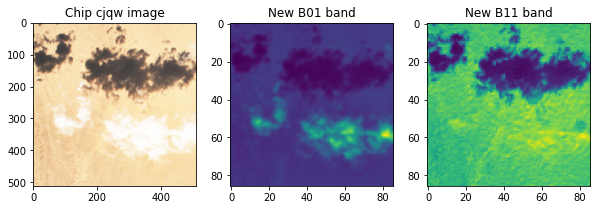

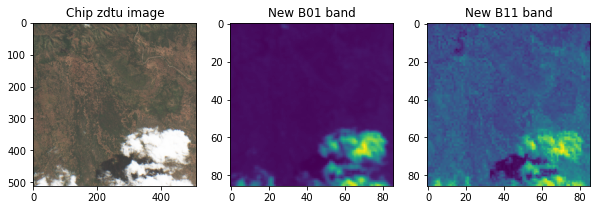

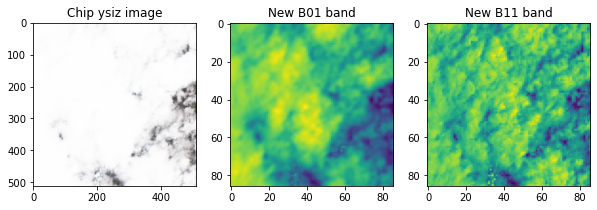

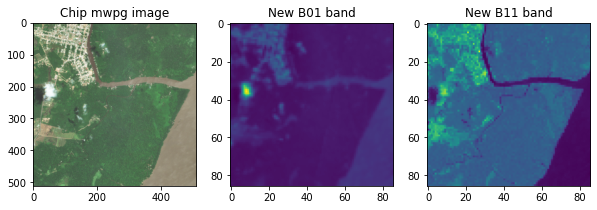

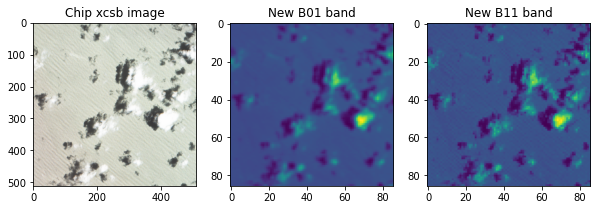

In [22]:
for row in train_subset.itertuples():
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(true_color_img(row.chip_id))
    ax[0].set_title(f"Chip {row.chip_id} image")
    ax[1].imshow(Image.open(row.B01_path))
    ax[1].set_title("New B01 band")
    ax[2].imshow(Image.open(row.B11_path))
    ax[2].set_title("New B11 band")
    plt.show()

Success! All of the new bands visually match the true color image of each chip.